In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from imblearn.metrics import geometric_mean_score
from predictors import stacking_model_pipe, cv_model
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

In [2]:
# https://www.kaggle.com/code/adaramit/customer-churn-working-with-imbalanced-dataset

In [41]:
df = pd.read_excel('data/Telco_Cust_Churn.xls')

In [42]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [43]:
df['Churn'] = df['Churn'].replace({"Yes":1,"No":0})

<Axes: xlabel='Churn', ylabel='count'>

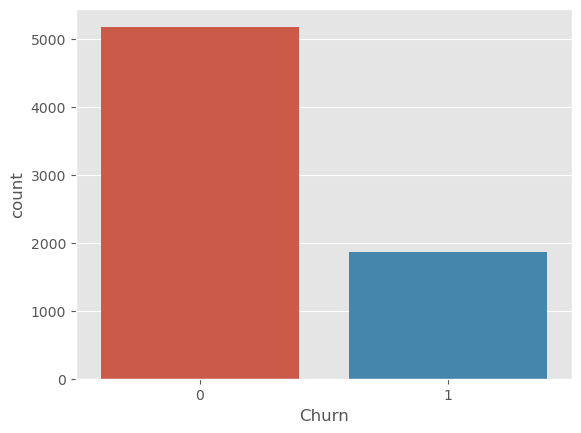

In [44]:
sns.countplot(x='Churn', data=df)

In [45]:
for c in [_ for _ in df.columns if df[_].dtype=='object']:
    print(c, df[c].unique())

customerID ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender ['Female' 'Male']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges [29.85 1889.5 108.15 ... 346.45 306.6 6844.5]


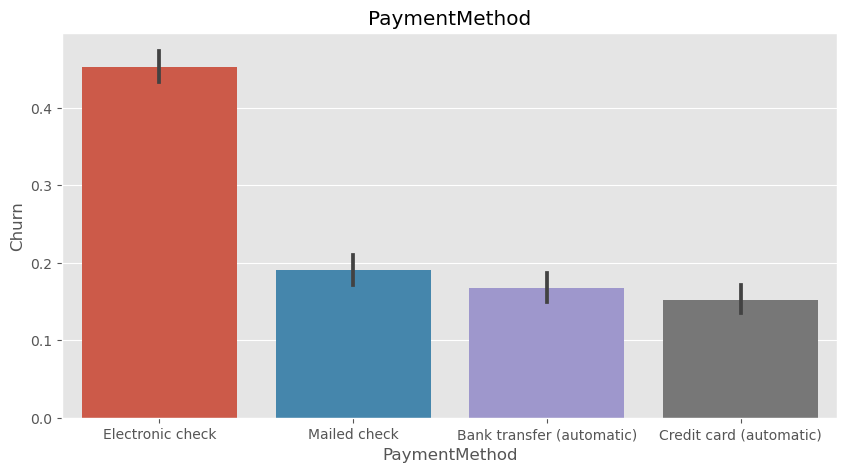

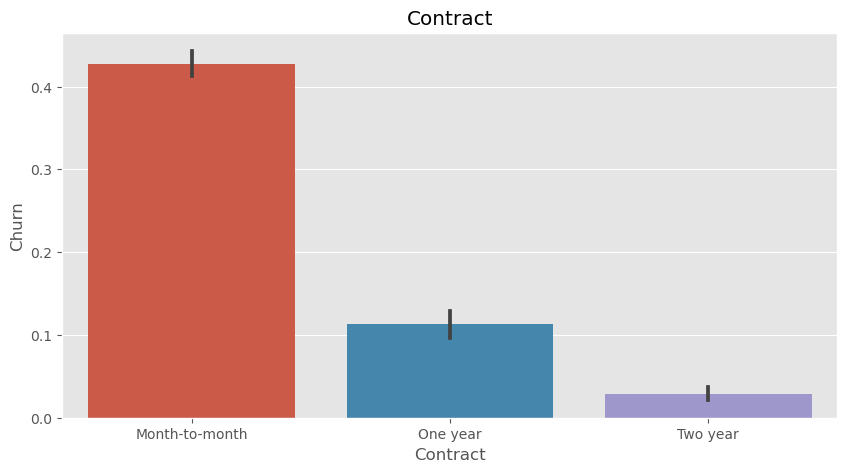

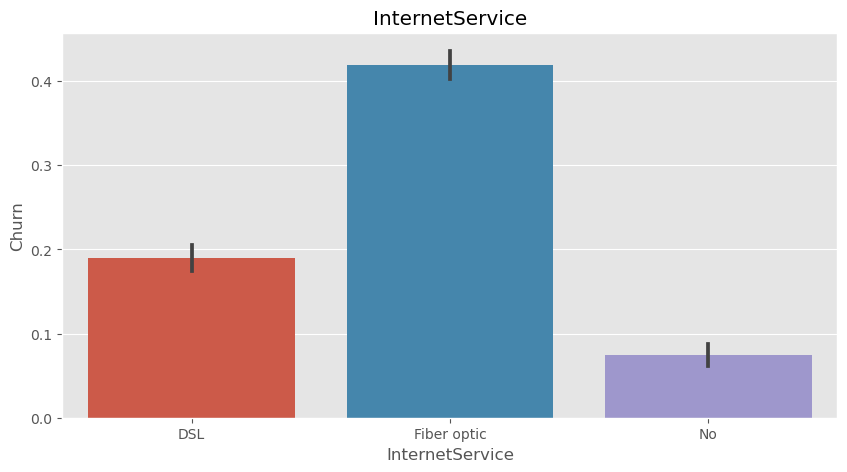

In [46]:
dummy = ['PaymentMethod', 'Contract', 'InternetService']

for d in dummy:
    plt.figure(figsize=(10,5))
    sns.barplot(x=d,y="Churn",data=df)
    plt.title(d)
    plt.show()

In [9]:
# Contract and InternetService should be ordinal
# from sklearn.preprocessing import OrdinalEncoder
# contract_encoder = OrdinalEncoder(categories=[["Two year", "One year", "Month-to-month"]])
# internet_encoder = OrdinalEncoder(categories=[["No", "DSL", "Fiber optic"]])
# df_contract = contract_encoder.fit_transform(df['Contract'].values.reshape(-1,1))
# df_internet = internet_encoder.fit_transform(df['InternetService'].values.reshape(-1,1))
# df_contract = pd.DataFrame(df_contract, columns=['Contract'])
# df_internet = pd.DataFrame(df_internet, columns=['InternetService'])

In [47]:
col_to_drop = ['customerID']
col_yes_no = ['Partner',
              'Dependents',
              'PhoneService',
              'MultipleLines',
              'OnlineSecurity', 
              'OnlineBackup', 
              'DeviceProtection',
              'TechSupport',
              'StreamingTV',
              'StreamingMovies',
              'PaperlessBilling',
              'Churn']

df_payment = pd.get_dummies(df['PaymentMethod'])
df_contract = df['Contract'].replace({"Two year": 0, "One year": 1, "Month-to-month": 2})
df_internet = df['InternetService'].replace({"No": 0, "DSL": 1, "Fiber optic": 2})

df = df.replace(regex=r'No\s[a-z]+\sservice', value='No')
df['gender'] = df['gender'].replace({"Female":0, "Male":1})
df[col_yes_no] = df[col_yes_no].replace({"Yes":1, "No": 0})

df.drop(col_to_drop, axis=1, inplace=True)
df.drop(dummy, axis=1, inplace=True)
df = pd.concat((df, df_contract, df_internet, df_payment), axis=1)

In [48]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].isnull().sum()

11

In [49]:
df = df.dropna(subset=['TotalCharges']) # gradboost handle NaN

In [13]:
# df.info()

In [50]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,7032.0,0.504693,0.500014,0.00,0.0000,1.000,1.0000,1.00
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
Partner,7032.0,0.482509,0.499729,0.00,0.0000,0.000,1.0000,1.00
Dependents,7032.0,0.298493,0.457629,0.00,0.0000,0.000,1.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
PhoneService,7032.0,0.903299,0.295571,0.00,1.0000,1.000,1.0000,1.00
MultipleLines,7032.0,0.421928,0.493902,0.00,0.0000,0.000,1.0000,1.00
OnlineSecurity,7032.0,0.286547,0.452180,0.00,0.0000,0.000,1.0000,1.00
OnlineBackup,7032.0,0.344852,0.475354,0.00,0.0000,0.000,1.0000,1.00
DeviceProtection,7032.0,0.343857,0.475028,0.00,0.0000,0.000,1.0000,1.00


In [64]:
df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr().style.background_gradient(cmap='RdYlGn')

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.246862,0.825880
MonthlyCharges,0.246862,1.000000,0.651065
TotalCharges,0.825880,0.651065,1.000000


<Axes: xlabel='tenure', ylabel='Count'>

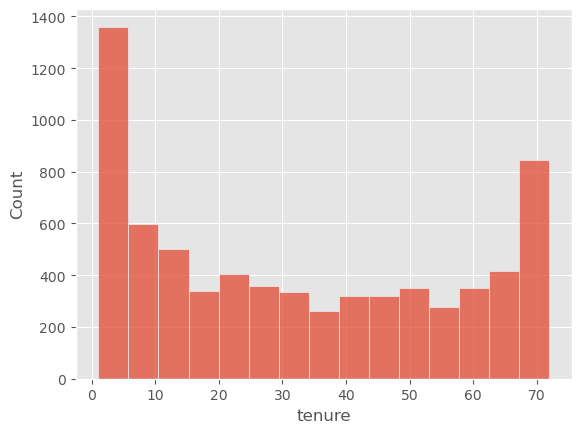

In [66]:
sns.histplot(df['tenure'])

In [51]:
y, X = df['Churn'], df.drop(['Churn'], axis=1)

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

model = XGBClassifier()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(classification_report(y_hat, y_test))
print(f1_score(y_test, y_hat), geometric_mean_score(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1105
           1       0.54      0.65      0.59       302

    accuracy                           0.81      1407
   macro avg       0.72      0.75      0.73      1407
weighted avg       0.82      0.81      0.81      1407

0.5907046476761619 0.6966627933721805


In [19]:
# X_train, y_train = SMOTE().fit_resample(X_train, y_train)
X_train, y_train = NearMiss(version=3).fit_resample(X_train, y_train)

In [60]:
params = {
    'n_estimators': np.linspace(10, 200, 10).astype(int),
    'learning_rate': np.linspace(0.01, 0.1, 10),
    "depth": np.linspace(1, 10, 5).astype(int),
    "subsample": np.linspace(0.05, 1.0, 10),
}
model = cv_model(cv=10, rand=True, model=CatBoostClassifier(verbose=0), params=params)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
print(classification_report(y_test, y_hat))
print(geometric_mean_score(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.85      0.92      0.89      1042
           1       0.71      0.54      0.61       365

    accuracy                           0.82      1407
   macro avg       0.78      0.73      0.75      1407
weighted avg       0.81      0.82      0.81      1407

0.7044673790305788


In [25]:
# import optuna
# import warnings
# from sklearn.model_selection import cross_val_score
# from catboost import CatBoostClassifier
# from sklearn.metrics import make_scorer, f1_score

# optuna.logging.set_verbosity(0)
# warnings.simplefilter(action='ignore', category=FutureWarning)

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 10, 200),
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
#         'depth': trial.suggest_int('depth', 1, 10),
#         'subsample': trial.suggest_uniform('subsample', 0.05, 1.0)
#     }
#     model = CatBoostClassifier(verbose=0, **params)
#     cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring=make_scorer(geometric_mean_score))
#     return cv_scores.mean()

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)
# best_params = study.best_params
# best_model = CatBoostClassifier(verbose=0, **best_params)
# best_model.fit(X_train, y_train)
# y_hat = best_model.predict(X_test)
# f1_score(y_test, y_hat), geometric_mean_score(y_test, y_hat)

In [26]:
# classifiers = [XGBClassifier(verbosity=0), LGBMClassifier(verbose=-1), CatBoostClassifier(verbose=0)]
# param_list = [params, params, params]

# ensemble, weak_learners = stacking_model_pipe(X=X_train,
#                                    y=y_train,
#                                    models=classifiers,
#                                    params=param_list,
#                                    final_estimator=MLPClassifier(),
#                                    model_type="classification")

# y_hat = ensemble.predict(X_test)
# ensemble_f1, ensemble_gm = f1_score(y_test, y_hat), geometric_mean_score(y_test, y_hat)
# ensemble_f1, ensemble_gm

In [27]:
# # # sanity check
# for i, model in enumerate(weak_learners):
#     y_hat_weak = model[1].predict(X_test)
#     f1,gm = f1_score(y_test, y_hat_weak), geometric_mean_score(y_test, y_hat_weak)
#     if f1 > ensemble_f1 or gm > ensemble_gm:
#         print(f'Weak learner {i} is better than ensemble: {f1} {gm}')

In [28]:
# # %%time
# rforest_params = {
#     'n_estimators': np.linspace(10, 1000, 10).astype(int),
# }

# forest = RandomForestClassifier()
# model = cv_model(cv=10, rand=True, model=RandomForestClassifier(), params=rforest_params)
# model.fit(X_train, y_train)
# y_hat = model.predict(X_test)
# print(f1_score(y_test, y_hat), geometric_mean_score(y_test, y_hat))
# random forest with SMOTE works very nice - similar scores to catboost

In [29]:
# TODO:
# variance thrsh, correlation plot, EDA

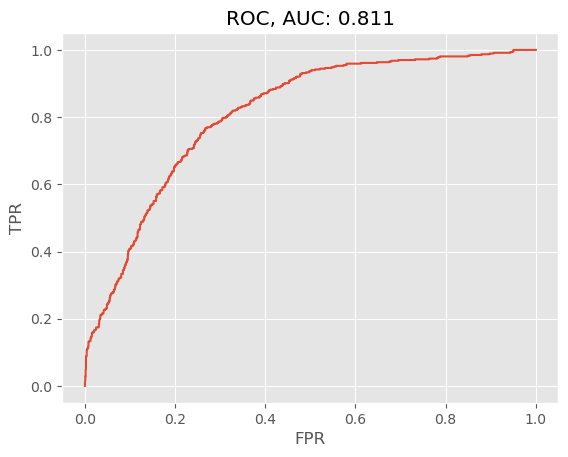

In [30]:
y_hat_proba = model.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_hat_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_hat_proba)

plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC, AUC: {round(auc,3)}')
plt.show()


In [31]:
# retraining
clf = CatBoostClassifier(verbose=0, **model.best_params_)

In [32]:
X = pd.concat((X_train, X_test), axis=0)
y = pd.concat((y_train, y_test), axis=0)
y

0       0
1       0
2       0
3       0
4       0
       ..
3829    1
1856    1
5967    1
4767    0
1075    0
Name: Churn, Length: 4566, dtype: int64

In [33]:
clf.fit(X,y)

In [34]:
# ...